In [1]:
# For data loading and scientific computing
import pandas as pd
import numpy as np
import random
import os
import csv

# For data visualization
import matplotlib.pyplot as plt
import plotly.express as px

# Deep learning framework
import torch
import torch.nn as nn

# data processing and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

import warnings
warnings.filterwarnings('ignore')

## Configuration

- `config`：集中管理參數的類別，方便調整超參數與環境參數訓練設定。  
- `batch_size`：一次訓練時送入模型的資料筆數，值越大，訓練更穩定但吃更多記憶體；越小則更新較快但較 noisy。  
- `learning rate`：控制模型更新參數的步伐，太大會跳來跳去，太小會收斂太慢。  
- `epoch`：每個 epoch 是完整掃過一次訓練資料。  
- `weight_decay`：正則化強度，權重值太大會被罰，幫助模型不要學得太複雜跟 overfitting。

In [2]:
class config:
    root = "/Users/tintsao/Desktop/交大統研所/碩一上/深度學習/DL_hw/Hw1/dataset"
    batch_size = 32
    lr = 1e-3
    epochs = 5
    weight_decay = 0.01  #對loss funtion的懲罰項，模型越複雜，loss會越大，有防止overfitting的用意。
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    seed = 49

## Utils

In [ ]:
def seed_everything(seed):
    # Set Python random seed
    random.seed(seed)
    
    # Set NumPy random seed
    np.random.seed(seed)
    
    # Set PyTorch random seed for CPU and GPU
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    
    # Set PyTorch deterministic operations for cudnn backend
    torch.backends.cudnn.deterministic = True  #True:相同輸入、相同模型、相同權重 每次都輸出一樣結果（可重現）
    torch.backends.cudnn.benchmark = False     #True:自動尋找最佳算法，提升運算效率，但為了重現性我們設成 False 。

## EDA

從下面的 dataframe 可以看出，第一個 column 表示每個樣本的類別，剩餘 256 個 columns 表示影像的灰階 pixel values

In [8]:
# Read in the dataframe
train_path = os.path.join(config.root, 'train.csv')
test_path = os.path.join(config.root, 'test.csv')

train_data = pd.read_csv(train_path, header=None)
test_data = pd.read_csv(test_path, header=None)

train_data.head(3)

,0,1,2,3,4,5,6,7,8,9,...,248,249,250,251,252,253,254,255,256,257
0,A1,6,-1.0,-1.0,-1.0,-1.000,-1.000,-1.000,-1.000,-0.631,...,0.304,0.823,1.000,0.482,-0.474,-0.991,-1.000,-1.000,-1.000,-1.0
1,A2,5,-1.0,-1.0,-1.0,-0.813,-0.671,-0.809,-0.887,-0.671,...,-0.671,-0.671,-0.033,0.761,0.762,0.126,-0.095,-0.671,-0.828,-1.0
2,A3,4,-1.0,-1.0,-1.0,-1.000,-1.000,-1.000,-1.000,-1.000,...,-1.000,-1.000,-1.000,-0.109,1.000,-0.179,-1.000,-1.000,-1.000,-1.0


In [9]:
train_data.iloc[:, 2:].describe() #總結資料集分佈的集中趨勢、離散度和形狀（不包括 NaN值）

,2,3,4,5,6,7,8,9,10,11,...,248,249,250,251,252,253,254,255,256,257
count,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,...,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000
mean,-0.996417,-0.981138,-0.951153,-0.887738,-0.773468,-0.610302,-0.368991,-0.045769,-0.052641,-0.284564,...,-0.198547,0.139823,0.116439,-0.314108,-0.653711,-0.837858,-0.922194,-0.957393,-0.979290,-0.994678
std,0.051713,0.151202,0.244264,0.360516,0.502659,0.628710,0.716032,0.768304,0.752979,0.746838,...,0.772895,0.752984,0.757336,0.725859,0.582555,0.414646,0.300830,0.228700,0.158998,0.066056
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.999000,-0.950000,-1.000000,...,-1.000000,-0.661500,-0.738000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.719000,0.061000,0.002000,-0.561000,...,-0.353000,0.368000,0.336000,-0.579000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
75%,-1.000000,-1.000000,-1.000000,-1.000000,-0.962000,-0.391000,0.254500,0.696000,0.674500,0.438000,...,0.554000,0.835000,0.815000,0.346000,-0.504500,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
max,0.638000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.592000


In [10]:
print(f"Number of training samples: {train_data.shape[0]}")
print(f"Number of testing samples: {test_data.shape[0]}")

Number of training samples: 7291
Number of testing samples: 2007


In [11]:
#計算 train_data 標籤數量
train_data.iloc[:, 1].value_counts().sort_index() 

1
0    1194
1    1005
2     731
3     658
4     652
5     556
6     664
7     645
8     542
9     644
Name: count, dtype: int64

## Show the number of images in each digit for the training dataset

首先取出 label 並計算每個出現的次數，接下來 label 的值由小到大排序。  
接著用 Bar Chart 把它畫出來。  

In [61]:
train_label_distribution = train_data.iloc[:, 1].value_counts().sort_index()
train_label_distribution = pd.DataFrame(
    {
        "labels": train_label_distribution.index.astype(str), #將int64改成str
        "number_of_samples": train_label_distribution.values
    }
)
# print(train_label_distribution)

#以下兩個是視覺化參數設定
fig = px.bar(
    train_label_distribution, x="labels", y="number_of_samples",
    labels=dict(y="number of samples"),
)
# update_layout 用來更新圖表的佈局配置，調整圖表的外觀和樣式
fig.update_layout(
    plot_bgcolor='white',
    xaxis=dict(showgrid=True, gridcolor='lightgray', zeroline=False),  # Show x-axis grid，zeroline=False為不顯示x=0那條線
    yaxis=dict(showgrid=True, gridcolor='lightgray', zeroline=False),  # Show y-axis grid，zeroline=False為不顯示y=0那條線
    title=dict(text="Number of Samples Per Labels", x=0.5, y=0.975, font=dict(size=20))
)
fig.show()

## Pytorch Dataset

pytorch dataset 必須為自定義物件，且須繼承於 `torch.utils.data.Dataset`。我們必須實現下列方法

- `__init__:` Initialization Setting
- `__len__:` return the length of the data
- `__getitem__:` return the data according to the index draw from sampler

Pandas 的 DataFrame 這種資料結構適合處理表格，但不適合用在DL當中，因為他不支援 GPU 運算跟自動微分的功能

所以，我們要轉成 torch.tensor ，專門為DL所設計的框架，支援上述所提及的功能。

但 Pandas 和 PyTorch 會有兼容性問題，有些複雜的資料結構會出意外，在這種情況下，我們會先轉成NumPy來確保相容。

In [13]:
class HandwrittenDigits(torch.utils.data.Dataset):
    def __init__(self, df, mode=None, transforms=None):
        self.df = df
        self.transforms = transforms 
        self.mode = mode
        
    def __len__(self):
        return len(self.df)
        
    def __getitem__(self, x):
        if self.mode == "train":
            ID = self.df.iloc[x, 0]                                 #抓取第 x 筆資料，第 0 欄為 image_id。
            label = self.df.iloc[x, 1]                              #抓取第 x 筆資料，第 1 欄為 image_label。
            image = self.df.iloc[x, 2:].to_numpy(dtype=np.float32)  #抓取第 x 筆資料，第 2 欄為 image 的 pixel。
            label, image = torch.tensor(label), torch.tensor(image)
            
            if self.transforms: #這個只會用在 train_data 身上，所以 valid_data 不用。
                transformed = self.transforms(image=image)
                image = transformed['image']
                
            return ID, label, image
        
        elif self.mode == "valid":
            ID = self.df.iloc[x, 0]                                 #抓取第 x 筆資料，第 0 欄為 image_id。
            label = self.df.iloc[x, 1]                              #抓取第 x 筆資料，第 1 欄為 image_label。
            image = self.df.iloc[x, 2:].to_numpy(dtype=np.float32)  #抓取第 x 筆資料，第 2 欄為 image 的 pixel。
            label, image = torch.tensor(label), torch.tensor(image)
            
            return ID, label, image
        
        elif self.mode == "test":
            ID = self.df.iloc[x, 0]
            image = self.df.iloc[x, 1:].to_numpy(dtype=np.float32) 
            image = torch.tensor(image)
            
            return ID, image  # 因為 test 沒 label

In [17]:
ds = HandwrittenDigits(train_data, mode = "train")
ds[0]

('A1',
 tensor(6),
 tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.6310,
          0.8620, -0.1670, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9920,  0.2970,
          1.0000,  0.3070, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.4100,  1.0000,
          0.9860, -0.5650, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.6830,  0.8250,  1.0000,
          0.5620, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -0.9380,  0.5400,  1.0000,  0.7780,
         -0.7150, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000,  0.1000,  1.0000,  0.9220, -0.4390,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         

## Pytorch DataLoader

怎麼讓neural network 批次(batch)讀取影像資料呢? 我們可以透過 pytorch dataloader 來達成，pytorch dataloader 包含三個部分

- sampler: 抽樣方式，主要是生出一組index。

    常見的抽樣方式包括：

    SequentialSampler: 順序抽樣，按照順序抽取資料。

    RandomSampler: 隨機抽樣，隨機抽取資料。

    SubsetRandomSampler: 從一個subset隨機抽樣。

- dataset: 對影像的處理方法，根據這組index提取相對應的資料。

    我們有自定義HandwrittenDigits，__getitem()__定義了如何讀取 image 與 label 。

- collate_fn: 對一個batch進行整合。

    Batch 是指在一次迭代（iteration）中， model 處理的資料樣本的數量。

    例如，1000個樣本，我可以設定每次迭代中使用 batch=32 (每次訓練都用32個樣本)。

    使用 Batch 可以在訓練過程中讓 gradient descent 更穩定、更平滑的更新，對於大型資料集可以避免一次性加載所有數據導致內存不足。

具體流程如下:
sampler --> indices --> dataset --> collate_fn

視覺化詳見 [https://twitter.com/_ScottCondron/status/1363494433715552259](https://twitter.com/_ScottCondron/status/1363494433715552259)

In [18]:
train_data = pd.read_csv(train_path, header=None)
train_dataset = HandwrittenDigits(train_data, mode = "train")
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True) #shuffle=True代表使用 RandomSampler。

## For each digit, plot 10 randomly selected images from your training dataset.

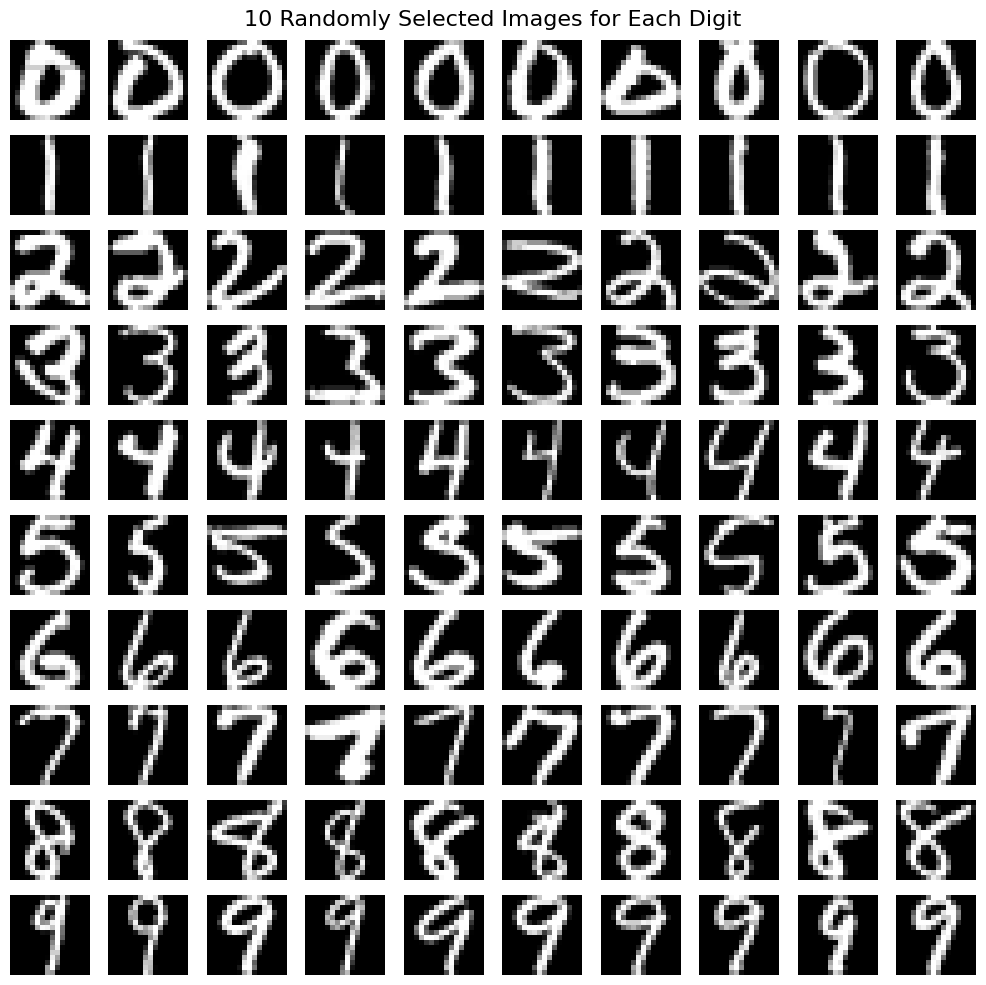

In [27]:
# 建立字典用來儲存 0~9 的圖像
digit_images = {i: [] for i in range(10)}
# print(digit_images)

# 從train_dataset抓取 label 跟 image，並將 image 重塑成 16x16，放進字典中。
for ID, label, image in train_dataset:
    digit_images[label.item()].append(image.numpy().reshape(16, 16))

# 繪製每個數字的隨機10張圖片
fig, axes = plt.subplots(10, 10, figsize=(10, 10))
fig.suptitle('10 Randomly Selected Images for Each Digit', fontsize=16)

for digit in range(10):
    # 隨機選擇10張圖片
    selected_images = random.sample(digit_images[digit], 10)
    for i, img in enumerate(selected_images):
        ax = axes[digit, i]                                   #axes 是一個 10x10 的 matplotlib 子圖
        ax.imshow(img, cmap='gray')
        ax.axis('off')

plt.tight_layout() #自動調整圖片間距，避免圖像太過緊密。
plt.show()

# Pytorch Module

Pytorch neural network 同樣也是需自定義的物件，我們必須實現兩種方法

- `__init__:` model 的初始化函數，用於定義模型的結構
- `forward:` 定義了 model 向前傳播的過程

這裡示範 Net-2: Two hidden layers with 64 and 16 nodes, respectively

### 簡單前饋神經網路
用來處理分類或回歸任務。屬於典型的 多層感知器（MLP, Multi-Layer Perceptron） 結構。

In [29]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)     # 隱藏層有 64 個神經元（hidden units）
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(64, 16)
        self.relu2 = nn.ReLU()
        self.final_fc = nn.Linear(16, output_dim)

    def forward(self, x):
        x = self.fc1(x) # y = Wx + b
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.final_fc(x)
        return x

In [30]:
input_dim =  256 # image 的 pixel 有 256
output_dim = 10  # 我們想要分類 0~9 其中一個類別

model = SimpleNN(input_dim, output_dim)
model

SimpleNN(
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=64, out_features=16, bias=True)
  (relu2): ReLU()
  (final_fc): Linear(in_features=16, out_features=10, bias=True)
)

## Evaluator

- `preds`: 模型預測的結果（通常是分類標籤）
- `gts`: ground truth，真實標籤（ground truths）

In [68]:
def evaluator(preds, gts):
    preds = preds.cpu().numpy() if isinstance(preds, torch.Tensor) else preds # 將 Tensor 轉成 numpy ，如果是 Tensor 的話
    gts = gts.cpu().numpy() if isinstance(gts, torch.Tensor) else gts
    
    acc = accuracy_score(preds, gts)             # 計算正確率
    f1 = f1_score(preds, gts, average="macro")   # F1 score，介在 0~1 ，對 model 分類性能的綜合評價，越高越好
    misclassification_rate = 1 - acc             # 計算分錯率
    
    return acc, f1, misclassification_rate

## Training

In [ ]:
def train_one_epoch(model, train_loader, optimizer, scheduler, criterion, device):
    model.train()                                            # PyTorch 中一個用來告知 model 進行訓練的狀態設置，會啟用一些用在訓練的層（如 dropout 和 batch normalization）
    train_loss = .0                                          # 累積一個 epoch 的總損失
    predictions, ground_truths = [], []                      # 儲存所有的預測結果和對應的真實標籤。
    for ID, labels, images in train_loader:
        labels = labels.to(device=device, dtype=torch.long)  # nn.CrossEntropyLoss 要求 label 必須是長整數型態，一般的 int 不行。
        images = images.to(device=device, dtype=torch.float) # 將 image 移動到指定的設備（例如 GPU）上，並確保其資料型態為 float。
        
        optimizer.zero_grad()                                # 清空 optimizer 的梯度，避免梯度累加
        logits = model(images)                               # 將 image 輸入 model ，計算輸出的 logits。
        loss = criterion(logits, labels)                     # 計算 model 輸出與真實標籤之間的損失（loss）
        loss.backward()                                      # 計算 loss 對 model 參數的梯度
        
        optimizer.step()                                     # 更新 model 參數
        
        train_loss += loss.item()                            # 將當前 batch 的損失累加到總損失中。
        preds = torch.argmax(logits, dim=1)                  # 獲取機率最大的類別，當作預測
        
        predictions.append(preds)                            # 新增預測結果
        ground_truths.append(labels)                         # 新增真實標籤
        
    scheduler.step()                                         # 更新 lr 的參數
    
    train_loss /= len(train_loader)                          # 計算整個 epoch 的平均損失
    
    predictions = torch.cat(predictions)                     # 將所有 batch 的預測結果拼成一個完整的張量。
    ground_truths = torch.cat(ground_truths)                 # 將所有的真實標籤拼成一個完整的張量。
    
    train_acc, train_f1, train_misclass = evaluator(predictions, ground_truths) # 計算當前 epoch 的 acc 、 F1 score 和 misclassification_rate
    
    return train_loss, 100*train_acc, 100*train_f1, 100*train_misclass

## Validation

In [ ]:
def validation(model, valid_loader, criterion, device):
    model.eval()
    valid_loss = .0
    predictions, ground_truths = [], []
    with torch.no_grad(): # 不計算梯度
        for ID, labels, images in valid_loader:
            labels = labels.to(device=device, dtype=torch.long)
            images = images.to(device=device, dtype=torch.float)
            
            # validation 不需要計算梯度，所以不用 optimizer 、 loss.backward() 、 scheduler
            logits = model(images)
            loss = criterion(logits, labels)
            
            valid_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
        
            predictions.append(preds)
            ground_truths.append(labels)
        
    valid_loss /= len(valid_loader)
    
    predictions = torch.cat(predictions)
    ground_truths = torch.cat(ground_truths)
    
    valid_acc, valid_f1, valid_misclass = evaluator(predictions, ground_truths)
    
    return valid_loss, 100*valid_acc, 100*valid_f1, 100*valid_misclass